# Feature extraction and reverse image search

This notebook will guide you through the procedure of analyzing a large set of images using a pre-trained convolutional network, and extracting feature vectors which represent each image. 

After the analysis is done, we will review some retrieval tasks that you can do with such an analysis. The main task will be that of "reverse image search," which refers to searching for the most similar set of images to some query image. 

### Prepare a dataset

You will need a folder of images to analyze. There is no limit to the size of the dataset, but for good results, at least 1000 would be good.

This notebook will use an example dataset called [Caltech-101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/), which contains roughly 9000 images in 101 categories. To get this dataset, please download it from [here](http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz) and unzip it into the `data` folder, or just run the following commands in a terminal from the folder this notebook is in.

    wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz -P data/.
    tar -xvzf data/101_ObjectCategories.tar.gz -C data/.
    
You may use a custom folder of images (which may have subfolders) instead if you wish.

We'll start by importing the relevant Keras libraries that we'll be using.

In [33]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model

Now we are going to load the VGG-16 pre-trained convolutional network which you can download from Keras automatically. Run the following command. If its your first time accessing VGG-16, it will setup a one-time download for you first.

In [34]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)

Let's look at the model summary to see how it's structured.

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

You can see from the summary that VGG-16 is setup to take a fixed-size (224 x 224 x 3) RGB image at its input, and then forward it through a series of altrnating convolutional and max-pooling layers, then capped off by three fully-connected layers of 4096, 4096, and 1000 neurons, where the last layer is our softmax classification layer.

Notice that the output shape at each layer has `None` the first dimension. This is because the network can process multiple images in a single batch. So if you forward 5 images at shape [5, 224, 224, 3], then the output shape at each layer will be 5 in the first dimension.

### Forwarding an image through the network

In order to input an image into the network, it has to be pre-processed into a feature vector of the correct size. The following function `load_image` will do all the pre-processing.

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

We'll load the image of the dog in the `data` directory, and take a look at its feature vector.

shape of x:  (1, 224, 224, 3)
data type:  float32


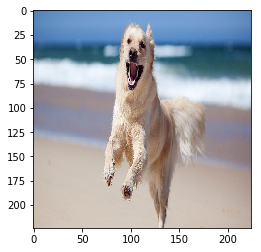

In [47]:
img, x = load_image("data/dog.jpg")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

The shape of the image is [1, 224, 224, 3]. The reason it has the extra first dimension with 1 element is that the network can take batches of images to process them all simultaneously. So for example, 10 images can be propagated through the network if `x` has a shape of [10, 224, 224, 3].

Let's get class predictions from this model. We forward `x` through `model` and then use the built-in `decode_predictions` to look up the class names.

In [55]:
# forward the image through the network
predictions = model.predict(x)

# print out the 
for _, pred, prob in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred, prob))

predicted Saluki with probability 0.887
predicted Afghan_hound with probability 0.060
predicted borzoi with probability 0.013
predicted whippet with probability 0.011
predicted Irish_wolfhound with probability 0.007


### Feature extraction

What we have in the `model` variable is a highly effective image classifier trained on the ImageNet database. We expect that the classifier must form a very effective representation of the image in order to be able to classify it with such high accuracy. We can use this to our advantage by re-purposing this for another task.

What we do is we copy the model, but remove the last layer (the classification layer), so that the final layer of the new network, called `feat_extractor` is the second 4096-neuron fully-connected layer.

The following code does this for us. In Keras, the easiest way to do this is by making a new model, whose input and output match the desired layers we want to use. It looks like a copy, but internally, all Keras is doing is making a pointer to each of these layers and not actually copying anything. Thus, the output "prediction" from `feat_extractor` will just be the layer `fc2` from `model`.

In [56]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

If we run `predict` on an image using `feat_extractor` we see we obtain the fc2 layer activations. We can lot them as below.

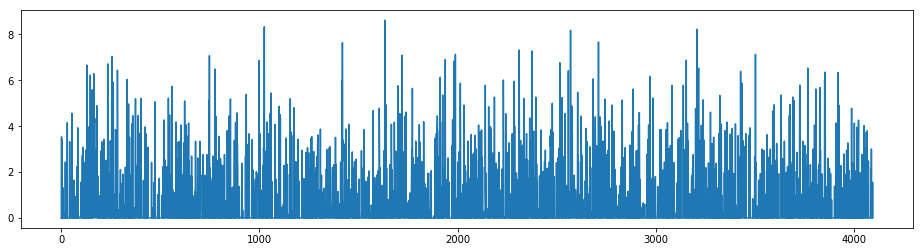

In [57]:
img, x = get_image("data/dog.jpg")
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

Our expectation is that the `fc2` activations form a very good representation of the image, such that similar images should produce similar activations. In other words, the `fc2` activations of two images which have similar content should be very close to each other. We can exploit this to do information retrieval. 

In the next cell, we will open a folder of images for analysis. First, the next cell will just recursively crawl the folder specified by `image_path` looking for images of the extensions inside of `image_extensions` and then limiting them to a random subset of maximum `max_num_images` images. Change these variables if you wish to change the target images.

In [58]:
images_path = 'data/101_ObjectCategories'
image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
max_num_images = 10000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 9144 images to analyze


In the next cell, we will begin a loop which will open each image, extract its feature vector, and append it to a list called `features` which will contain our activations for each image. This process may take a long time depending on your graphics card, so you may need to leave it running for as much as a few hours. On a good graphics card, this process may only take a half hour or so. Every 1000 images, you will receive a notification print-out.

In [22]:
features = []
for i, image_path in enumerate(images):
    if i % 1000 == 0:
        print("analyzing image %d / %d" % (i, len(images)))
    img, x = get_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

analyzing image 0 / 9144
analyzing image 1000 / 9144
analyzing image 2000 / 9144
analyzing image 3000 / 9144
analyzing image 4000 / 9144
analyzing image 5000 / 9144
analyzing image 6000 / 9144
analyzing image 7000 / 9144
analyzing image 8000 / 9144
analyzing image 9000 / 9144
finished extracting features for 9144 images


After our feature extraction is done, we have a list of `n` feature vectors of length `m`, where `n` is your number of images (9144 in all of CalTech-101) and `m = 4096` if you used the default Keras VGG-16 network.

Alone, these activations provide a good representation, but it is a good idea to do one more step before using these as our feature vectors, which is to do a [principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) to reduce the dimension down to 300. Please refer to the video lecture for a complete explanation of how PCA works. We apply PCA for two reasons: 1) the 4096-bit feature vector may have some redundancy in it, such that multiple elements in the vector are highly correlated or similar. This would skew similarity comparisons towards those over-represented features. 2) Operating over 4096 elements is inefficient both in terms of space/memory requirements and processor speed, and it would be better for us if we can reduce the length of these vectors but maintain the same effective representation. PCA allows us to do this by reducing the dimensionality down of the feature vectors from 4096 to much less, but maintain a representation which is still faithful to the original data, by preserving the relative inter-point distance.

The next cell will instantiate a `PCA` object, which we will then fit our data to, choosing to keep the top 300 principal components. This may take a few minutes

In [24]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)

The `pca` object stores the actual transformation matrix which was fit in the previous cell. We can now use it to transform any original feature vector (of length 4096) into a reduced 300-dimensional feature vector in the principal component space found by the PCA. 

So we take our original feature vectors, and transform them to the new space.

In [ ]:
pca_features = pca.transform(features)

now `pca_features` is a list of `n` feature vectors, except each feature vector is now 300 elements long (or whatever number of components the PCA was set to keep before the original fitting.

The assumption we can now make is that two images which have similar content, should produce similar feature vectors. The next two cells will randomly select one image, and then compute a measurement of the dissimilarity (or distance) of that image's PCA feature vector to every other image's feature vector. The dussimilarity metric we use is [cosine distance](https://en.wikipedia.org/wiki/Cosine_similarity). 

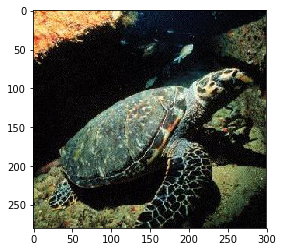

In [84]:
import random

# grab a random query image
query_image_idx = int(len(images) * random.random())

# let's display the image
img = image.load_img(images[query_image_idx])
plt.imshow(img)

Now compute dissimilarity with cosine distance.

In [86]:
from scipy.spatial import distance

similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

The list `similar_idx` contains the image's similarity to every other one. We can sort that list and find the indexes of the most similar images. The next cell will sort them, and then find the most similar items, and return the indexes 5 most similar images. Notice we take from indexes 1:6 rather than 0:5 because the most similar image to the query image, will trivially be the query image itself, since it is included in the distance calculation. So we just skip it.

In [87]:
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]

The next cell opens the images specified by `idx_closest` and concatenates them into a single image (resizing each so it has a height of 100 pixels.

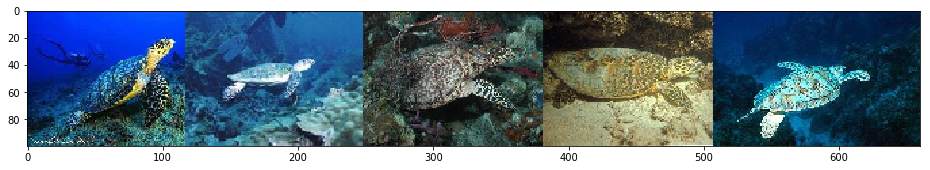

In [89]:
# load all the similarity results as thumbnails of height 100
thumbs = []
for idx in idx_closest:
    img = image.load_img(images[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)


The next cell just puts this process above into two convenience functions, `get_closest_images` and `get_concatenated_images`. 

In [90]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.euclidean(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image


So now we can do our lookups like this:

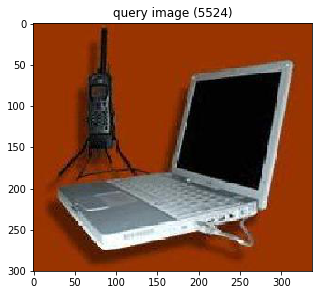

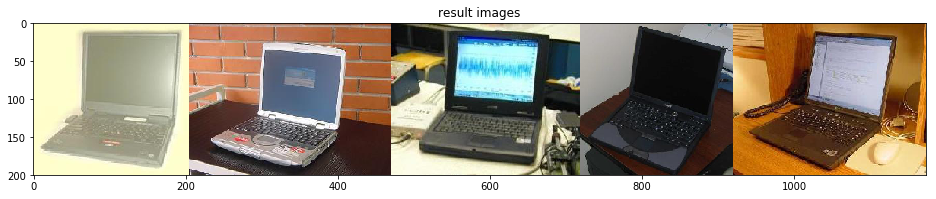

In [93]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

And again...

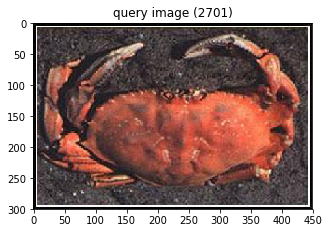

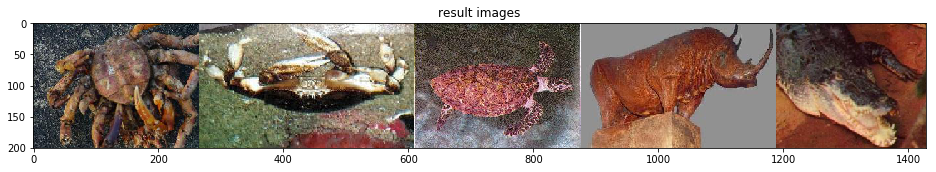

In [94]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

### How to project a new image into the space

or donload image from online


Thus we can see the usefulness of feature vectors for tasks other than classification. Besides for similarity retrieval, these feature vectors can be broadly useful for other things. The next two notebooks will show what else we can do with them. To make them accessible to those notebooks, let's first save our feature vectors and image paths to a new file. We can do this using `pickle`.

In [97]:
import pickle

pickle.dump([images, pca_features, pca], open('data/features_caltech101.p', 'wb'))

# later you can load it back

